In [1]:
# For vast.ai
# !git clone https://github.com/sobiodum/quantumai2.git
# !pip3 install --no-cache-dir -r requirements.txt

In [2]:
import gymnasium as gym
import pandas as pd
import matplotlib.pyplot as plt
import time
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances
import joblib
import numpy as np
from stable_baselines3 import A2C
from stable_baselines3.common.vec_env import VecNormalize, DummyVecEnv
from env.flo_portfolio import FlorianPortfolioEnv
from env.portfolio_multi_reward import FlorianPortfolioEnvMultiReward
from env.portfolio_bbg import Portfolio_BBG
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.callbacks import ProgressBarCallback,CallbackList, EvalCallback
from models.callbacks import CustomCallBack, HParamCallback, TensorboardCallback
from models.models import DRLAgent
from gymnasium import spaces
from pyfolio import timeseries
import pyfolio
from plot.plot import convert_daily_return_to_pyfolio_ts, convert_account_value_to_pyfolio_ts, get_baseline, backtest_stats, get_daily_return
from hyperoptimizer.optunaoptimizer import optimize_optuna, optimize_optuna_FlorianPortfolioEnvMultiReward, optimize_optuna_BBG_Env
from configs import tickers
from preprocessors.preprocessors import DataProcessor
# from wandb_env import wandb_opt
import requests
from datetime import datetime, timedelta
import calendar
from eod import EodHistoricalData
from pytz import timezone
import pandas_market_calendars as mcal
from stockstats import StockDataFrame




/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/pyfolio/pos.py:25: UserWarning:

Module "zipline.assets" not found; multipliers will not be applied to position notionals.



In [3]:
tic_start = "2014-04-01"
tic_start_unix = "1396337400"
tic_end = "2023-08-02"
tic_end_unix = "1691008200"

#Round1 Wed Feb 02 2022 09:35:00 GMT+0100 until Wed Aug 02 2023 19:00:00 GMT+0200 
round1_start_unix = "1643790900"
round1_end_unix = "1691008200"
#Round1 Wed Feb 02 2022 09:35:00 GMT+0100 until Wed Aug 02 2023 19:00:00 GMT+0200 
round2_start_unix = "1381649700"
round2_end_unix = "1602574500"

API Call Alpha Vntage

In [4]:
def get_intraday_eod(tickers, start, end, interval_len):
    client = EodHistoricalData("64cbaf10539312.00750558")
    data_df = pd.DataFrame()
    for ticker in tickers:
        try:
            resp = client.get_prices_intraday(ticker, interval=interval_len, from_=start, to=end)
            temp_df = pd.DataFrame(resp)
            if len(temp_df) > 0:
                # temp_df = temp_df.drop(columns=['timestamp','gmtoffset'])
                temp_df['ticker'] = ticker
                data_df = pd.concat([data_df, temp_df], axis=0)
            else:
                print(f"Dataframe empty for ticker: {ticker}")
        except Exception as e:
            print(f"Error fetching data for ticker {ticker}: {e}")
    return data_df


# tickers = ["GSIT.US",'IMGN.US']
# interval_len = "1m"
# start = tic_start_unix
# end = tic_end_unix

# df = get_intraday_eod(tickers, start, end, interval_len)
# df

In [5]:
def initial_fetch():
    shortened = ['GSIT.US', 'IMGN.US', 'BIDU.US',  'MARK.US',  'EVGN.US', 'ATEN.US', 'AMD.US', 'CTSH.US', 'CVLT.US', 'EPAM.US', 'EXLS.US', 'FTNT.US', 'G.US', 'LPSN.US', 'PRFT.US', 'PERI.US', 'PTC.US', 'QLYS.US', 'CRM.US', 'SSTK.US', 'SSNC.US', 'VMW.US']
    start_date = '2014-04-01'
    end_date = '2023-08-02'
    # Convert them to datetime objects
    start_date = datetime.strptime(start_date, "%Y-%m-%d")
    end_date = datetime.strptime(end_date, "%Y-%m-%d")
    # Initialize the start and end dates for the first 120-day period
    period_start_date = start_date
    period_end_date = start_date + timedelta(days=100) # Subtract one to avoid overlap with next period
    data_df = pd.DataFrame()
    # Loop over 120-day periods
    while period_end_date <= end_date:
        # Convert dates to UNIX timestamp
        period_start_unix = int(time.mktime(period_start_date.timetuple()))
        period_end_unix = int(time.mktime(period_end_date.timetuple()))

        # Fetch and process data for this period
            

        try:
            temp_df = get_intraday_eod(tickers=shortened, start=period_start_unix, end=period_end_unix, interval_len="1m")
            if len(temp_df) > 0:
                data_df = pd.concat([data_df, temp_df], axis=0)
                data_df.to_csv("data_df_while_loading.csv")
            else:
                print(f"Dataframe empty for ticker: {period_start_unix}")
        except Exception as e:
            print(f"Error fetching data for ticker {period_start_unix}: {e}")
        # Update the start and end dates for the next 120-day period
        period_start_date = period_end_date + timedelta(days=1)
        period_end_date = period_start_date + timedelta(days=100)
    return data_df


In [6]:
# data_df.to_pickle('large_data_df.pkl')

In [7]:
df = pd.read_pickle('large_data_df.pkl')
df = df.drop(columns=['timestamp', "gmtoffset"])
df['datetime'] = pd.to_datetime(df['datetime'])
#Remove some tickers as timeseries is bad

df = df[~df['ticker'].isin(['EVGN.US', 'MARK.US', 'GSIT.US'])]


# Set the current timezone of the datetime column
df['datetime'] = df['datetime'].dt.tz_localize('UTC')

# Convert the timezone from UTC to New York time
df['datetime'] = df['datetime'].dt.tz_convert('America/New_York')

# Remove outside extended trading hours
df = df.set_index('datetime')
df = df.between_time('9:30', '16:00')

# Shift the time by 30 minutes
df.index = df.index - pd.Timedelta(minutes=30)

# Resample to 60-minute intervals
df = df.groupby('ticker').resample('60T').agg({
    'open': 'first',
    'high': 'max',
    'low': 'min',
    'close': 'last',
    'volume': 'sum'
})

# Shift the time back by 30 minutes
df = df.reset_index()
df['datetime'] = df['datetime'] + pd.Timedelta(minutes=30)

# Filter the data to only include times between 9:30 and 16:00
df = df.set_index('datetime')
df = df.between_time('9:30', '16:00').reset_index()
# Get the NYSE calendar
nyse = mcal.get_calendar('NYSE')

# Get the market schedule for the date range in your data
schedule = nyse.schedule(start_date=df['datetime'].min(), end_date=df['datetime'].max())

# Compare the date part of 'datetime' in df with the date in schedule
df = df[df['datetime'].dt.date.isin(schedule.index.date)]

df


,datetime,ticker,open,high,low,close,volume
0,2014-04-01 09:30:00-04:00,AMD.US,4.040,4.10,4.020,4.030,4385118.0
1,2014-04-01 10:30:00-04:00,AMD.US,4.035,4.05,4.030,4.050,2484070.0
2,2014-04-01 11:30:00-04:00,AMD.US,4.050,4.07,4.040,4.050,1488290.0
3,2014-04-01 12:30:00-04:00,AMD.US,4.045,4.05,4.030,4.045,1602936.0
4,2014-04-01 13:30:00-04:00,AMD.US,4.040,4.06,4.040,4.055,972658.0
...,...,...,...,...,...,...,...
443151,2023-05-15 11:30:00-04:00,VMW.US,123.840,124.00,123.410,123.770,52823.0
443152,2023-05-15 12:30:00-04:00,VMW.US,123.810,124.44,123.750,124.200,38264.0
443153,2023-05-15 13:30:00-04:00,VMW.US,124.080,124.19,123.680,123.980,52545.0
443154,2023-05-15 14:30:00-04:00,VMW.US,123.960,124.05,123.630,123.980,94191.0


In [8]:
df.isna().any()

datetime    False
ticker      False
open         True
high         True
low          True
close        True
volume      False
dtype: bool

In [9]:
# Rename columns
df = df.rename(columns={'datetime': 'date',"ticker": "tic"})

# Forward fill missing values within each ticker group
df = df.groupby('tic').apply(lambda group: group.ffill()).reset_index(drop=True)

# Sort DataFrame by date and tic
df = df.sort_values(['date','tic'],ignore_index=True)

# Set index based on factorized date
df.index = df["date"].factorize()[0]

# Drop rows with missing values
df = df.dropna(axis=0)
df

,date,tic,open,high,low,close,volume
0,2014-04-01 09:30:00-04:00,AMD.US,4.040,4.100,4.020,4.030,4385118.0
0,2014-04-01 09:30:00-04:00,ATEN.US,15.100,15.100,14.900,15.020,60831.0
0,2014-04-01 09:30:00-04:00,BIDU.US,155.200,159.600,155.120,158.863,1766634.0
0,2014-04-01 09:30:00-04:00,CRM.US,57.610,58.840,57.600,58.430,1411792.0
0,2014-04-01 09:30:00-04:00,CTSH.US,50.780,51.280,50.570,51.245,550852.0
...,...,...,...,...,...,...,...
16078,2023-05-15 15:30:00-04:00,PTC.US,130.945,131.060,130.650,130.780,110993.0
16078,2023-05-15 15:30:00-04:00,QLYS.US,116.565,117.300,116.460,117.300,61376.0
16078,2023-05-15 15:30:00-04:00,SSNC.US,55.315,55.320,55.200,55.280,144766.0
16078,2023-05-15 15:30:00-04:00,SSTK.US,52.970,53.135,52.900,52.960,476964.0


In [10]:
df.isna().any()

date      False
tic       False
open      False
high      False
low       False
close     False
volume    False
dtype: bool

In [11]:

df.to_csv("checking_na_fields.csv")

In [12]:
ticker_counts = df.groupby('tic').count()
ticker_counts

,date,open,high,low,close,volume
tic,,,,,,
AMD.US,16079,16079,16079,16079,16079,16079
ATEN.US,16079,16079,16079,16079,16079,16079
BIDU.US,16079,16079,16079,16079,16079,16079
CRM.US,16079,16079,16079,16079,16079,16079
CTSH.US,16079,16079,16079,16079,16079,16079
CVLT.US,16079,16079,16079,16079,16079,16079
EPAM.US,16079,16079,16079,16079,16079,16079
EXLS.US,16079,16079,16079,16079,16079,16079
FTNT.US,16079,16079,16079,16079,16079,16079


In [13]:
df.to_pickle("1h_data_pretech.pkl")

Handling data done - before adding technicals

In [18]:
df = pd.read_pickle("1h_data_pretech.pkl")
df

,date,tic,open,high,low,close,volume
0,2014-04-01 09:30:00-04:00,AMD.US,4.040,4.100,4.020,4.030,4385118.0
0,2014-04-01 09:30:00-04:00,ATEN.US,15.100,15.100,14.900,15.020,60831.0
0,2014-04-01 09:30:00-04:00,BIDU.US,155.200,159.600,155.120,158.863,1766634.0
0,2014-04-01 09:30:00-04:00,CRM.US,57.610,58.840,57.600,58.430,1411792.0
0,2014-04-01 09:30:00-04:00,CTSH.US,50.780,51.280,50.570,51.245,550852.0
...,...,...,...,...,...,...,...
16078,2023-05-15 15:30:00-04:00,PTC.US,130.945,131.060,130.650,130.780,110993.0
16078,2023-05-15 15:30:00-04:00,QLYS.US,116.565,117.300,116.460,117.300,61376.0
16078,2023-05-15 15:30:00-04:00,SSNC.US,55.315,55.320,55.200,55.280,144766.0
16078,2023-05-15 15:30:00-04:00,SSTK.US,52.970,53.135,52.900,52.960,476964.0


In [5]:
# dp = DataProcessor()

# df = dp.add_stockstats_technical_indicator_1h_data(df)
# df

TA-LIB

In [1]:
# # Define your custom MACD periods
# fastperiod = 78
# slowperiod = 169
# signalperiod = 59
# # Define your custom RSI and SMA periods
# rsi_period = 91 #14days
# sma_period = 325 #50days

# # Define a function that calculates MACD and returns a DataFrame
# def calculate_macd(group):
#     macd, macds, macdh = talib.MACD(group['close'], fastperiod, slowperiod, signalperiod)
#     return pd.DataFrame({
#         'macd': macd,
#         'macds': macds,
#         'macdh': macdh
#     }, index=group.index)

# def calculate_indicators(group):
#     rsi = talib.RSI(group['close'], timeperiod=rsi_period)
#     sma = talib.SMA(group['close'], timeperiod=sma_period)
#     return pd.DataFrame({
#         'rsi': rsi,
#         'sma': sma
#     }, index=group.index)

# # Calculate MACD for each ticker
# macd_df = df.groupby('tic').apply(calculate_macd)

# # Reset the index of macd_df
# macd_df = macd_df.reset_index(level=0, drop=True)

# # Join the MACD DataFrame back to the original DataFrame
# df = df.join(macd_df)

# # Calculate RSI and SMA for each ticker
# indicator_df = df.groupby('tic').apply(calculate_indicators)

# # Reset the index of indicator_df
# indicator_df = indicator_df.reset_index(level=0, drop=True)

# # Join the indicator DataFrame back to the original DataFrame
# df = df.join(indicator_df)

NameError: name 'df' is not defined

Technicals using pd

In [19]:
# Define your custom RSI, SMA, and MACD periods
rsi_period = 91
sma_period = 325
macd_fastperiod = 78
macd_slowperiod = 169
macd_signalperiod = 59
# df = df.reset_index(ignore_index=True)

# get all unique tickers
tickers = df['tic'].unique()

# prepare an empty DataFrame to collect the results
result_df = pd.DataFrame()

for ticker in tickers:
    ticker_df = df[df['tic'] == ticker].copy()

    # Calculate RSI
    delta = ticker_df['close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    average_gain = gain.rolling(window=rsi_period).mean()
    average_loss = loss.rolling(window=rsi_period).mean()
    rs = average_gain / average_loss
    rsi = 100 - (100 / (1 + rs))
    ticker_df['rsi'] = rsi

    # Calculate SMA
    ticker_df['sma'] = ticker_df['close'].rolling(window=sma_period).mean()

    # Calculate MACD
    ema_fast = ticker_df['close'].ewm(span=macd_fastperiod).mean()
    ema_slow = ticker_df['close'].ewm(span=macd_slowperiod).mean()
    ticker_df['macd'] = ema_fast - ema_slow
    ticker_df['macds'] = ticker_df['macd'].ewm(span=macd_signalperiod).mean()
    ticker_df['macdh'] = ticker_df['macd'] - ticker_df['macds']

    # Append the ticker_df to the result_df
    result_df = pd.concat([result_df, ticker_df], ignore_index=True)

# Reset the index
result_df = result_df.set_index(['date', 'tic'])

# Drop NA values
result_df = result_df.dropna(axis=0)

df = result_df.copy()
df

,,open,high,low,close,volume,rsi,sma,macd,macds,macdh
date,tic,,,,,,,,,,
2014-06-06 11:30:00-04:00,AMD.US,4.09,4.10,4.090,4.100,846193.0,51.065099,4.004264,0.002949,-0.000451,0.003400
2014-06-06 12:30:00-04:00,AMD.US,4.10,4.10,4.080,4.080,703467.0,50.000000,4.004418,0.003693,-0.000313,0.004006
2014-06-06 13:30:00-04:00,AMD.US,4.08,4.10,4.080,4.085,1171210.0,50.629382,4.004526,0.004476,-0.000153,0.004629
2014-06-06 14:30:00-04:00,AMD.US,4.08,4.09,4.060,4.070,1108597.0,49.579408,4.004587,0.005028,0.000019,0.005009
2014-06-06 15:30:00-04:00,AMD.US,4.07,4.07,4.060,4.060,663685.0,49.165832,4.004634,0.005426,0.000200,0.005226
...,...,...,...,...,...,...,...,...,...,...,...
2023-05-15 11:30:00-04:00,VMW.US,123.84,124.00,123.410,123.770,52823.0,50.222941,122.951426,-0.178514,0.154937,-0.333451
2023-05-15 12:30:00-04:00,VMW.US,123.81,124.44,123.750,124.200,38264.0,50.730954,122.964257,-0.167177,0.144200,-0.311378
2023-05-15 13:30:00-04:00,VMW.US,124.08,124.19,123.680,123.980,52545.0,50.384151,122.976949,-0.159190,0.134087,-0.293277


In [20]:
df.to_pickle("final_stock_df.pkl")

                           macd macds macdh
date                                       
2014-04-01 09:30:00-04:00  None  None  None
2014-04-01 09:30:00-04:00  None  None  None
2014-04-01 09:30:00-04:00  None  None  None
2014-04-01 09:30:00-04:00  None  None  None
2014-04-01 09:30:00-04:00  None  None  None
...                         ...   ...   ...
2023-05-15 15:30:00-04:00  None  None  None
2023-05-15 15:30:00-04:00  None  None  None
2023-05-15 15:30:00-04:00  None  None  None
2023-05-15 15:30:00-04:00  None  None  None
2023-05-15 15:30:00-04:00  None  None  None

[305501 rows x 3 columns]


In [4]:
train_start = "1980-01-02"
train_end = "2015-12-31"
validate_start = "2016-01-01"
validate_end = "2019-12-31"
test_start = "2020-01-01"
test_end = "2023-07-28"

Load BBG Data

,date,.AAIIB2B G Index,.DMASPX G Index,.NETBULL G Index,.NGCM% G Index,.SPE10YBR G Index,.SPPE2YBR G Index,.SPX%FWD G Index,.SPXPE G Index,AAIIBEAR Index,...,USPESPPE Index,USURTOT Index,USYC1030 Index,USYC2Y10 Index,USYC2Y5Y Index,USYC3M2Y Index,USYC5Y30 Index,VIX Index,VIX3M Index,CESIUSD Index
0,1980-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1980-01-02,NaN,0.7937,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-89.65,NaN,NaN,NaN,NaN,NaN,NaN
2,1980-01-03,NaN,0.8575,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-85.65,NaN,NaN,NaN,NaN,NaN,NaN
3,1980-01-04,NaN,0.9519,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-81.65,NaN,NaN,NaN,NaN,NaN,NaN
4,1980-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,date,tic,LAST_PRICE,PX_HIGH,PX_LOW,PX_Open,PX_VOLUME,type
0,1980-01-02,SPX Index,105.76,105.76,105.76,105.76,NaN,asset
1,1980-01-03,SPX Index,105.22,105.22,105.22,105.22,NaN,asset
2,1980-01-04,SPX Index,106.52,106.52,106.52,106.52,NaN,asset
3,1980-01-07,SPX Index,106.81,106.81,106.81,106.81,NaN,asset
4,1980-01-08,SPX Index,108.95,108.95,108.95,108.95,NaN,asset


Process & Merge Data

,date,.AAIIB2B G Index,.DMASPX G Index,.NETBULL G Index,.NGCM% G Index,.SPE10YBR G Index,.SPPE2YBR G Index,.SPX%FWD G Index,.SPXPE G Index,AAIIBEAR Index,...,USPESPPE Index,USURTOT Index,USYC1030 Index,USYC2Y10 Index,USYC2Y5Y Index,USYC3M2Y Index,USYC5Y30 Index,VIX Index,VIX3M Index,CESIUSD Index
0,1980-01-01,1.428803,2.568428,-24.935431,13.236545,1.48163,4.587311,8.937552,19.987668,31.064779,...,19.155906,6.13531,54.870483,94.236742,54.855534,50.685467,106.82154,19.561413,21.079464,5.017354
1,1980-01-02,1.428803,0.793700,-24.935431,13.236545,1.48163,4.587311,8.937552,19.987668,31.064779,...,19.155906,6.13531,54.870483,-89.650000,54.855534,50.685467,106.82154,19.561413,21.079464,5.017354
2,1980-01-03,1.428803,0.857500,-24.935431,13.236545,1.48163,4.587311,8.937552,19.987668,31.064779,...,19.155906,6.13531,54.870483,-85.650000,54.855534,50.685467,106.82154,19.561413,21.079464,5.017354
3,1980-01-04,1.428803,0.951900,-24.935431,13.236545,1.48163,4.587311,8.937552,19.987668,31.064779,...,19.155906,6.13531,54.870483,-81.650000,54.855534,50.685467,106.82154,19.561413,21.079464,5.017354
4,1980-01-05,1.428803,0.951900,-24.935431,13.236545,1.48163,4.587311,8.937552,19.987668,31.064779,...,19.155906,6.13531,54.870483,-81.650000,54.855534,50.685467,106.82154,19.561413,21.079464,5.017354
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15910,2023-07-24,2.390700,6.897900,2.800000,15.350700,1.43070,1.126400,38.260000,21.877100,21.500000,...,18.040000,3.60000,4.775000,-105.090000,-77.188000,-50.445000,-23.08700,13.910000,16.260000,65.200000
15911,2023-07-25,2.390700,7.009800,2.800000,17.622000,1.42590,1.136500,38.260000,21.938700,21.500000,...,18.040000,3.60000,3.843000,-99.618000,-71.309000,-57.746000,-24.04900,13.860000,16.220000,70.300000
15912,2023-07-26,2.390700,7.119400,2.800000,17.622000,1.43250,1.142100,38.260000,21.935300,21.500000,...,18.040000,3.60000,6.172000,-98.895000,-73.945000,-60.470000,-18.35900,13.190000,15.790000,68.200000
15913,2023-07-27,1.863100,7.198400,-10.200000,17.622000,1.38500,1.124000,38.260000,21.794400,24.100000,...,18.040000,3.60000,3.277000,-93.449000,-69.415000,-51.397000,-20.50700,14.410000,16.630000,81.900000


,date,tic,close,high,low,open,volume,type
0,1980-01-02,SPX Index,105.76,105.76,105.76,105.76,NaN,asset
1,1980-01-03,SPX Index,105.22,105.22,105.22,105.22,NaN,asset
2,1980-01-04,SPX Index,106.52,106.52,106.52,106.52,NaN,asset
3,1980-01-07,SPX Index,106.81,106.81,106.81,106.81,NaN,asset
4,1980-01-08,SPX Index,108.95,108.95,108.95,108.95,NaN,asset


,date,tic,close,high,low,open,volume,type
0,1980-01-02,SPX Index,105.76,105.76,105.76,105.76,7.528438e+08,asset
1,1980-01-03,SPX Index,105.22,105.22,105.22,105.22,7.528438e+08,asset
2,1980-01-04,SPX Index,106.52,106.52,106.52,106.52,7.528438e+08,asset
3,1980-01-07,SPX Index,106.81,106.81,106.81,106.81,7.528438e+08,asset
4,1980-01-08,SPX Index,108.95,108.95,108.95,108.95,7.528438e+08,asset
...,...,...,...,...,...,...,...,...
10998,2023-07-24,SPX Index,4554.64,4563.41,4541.29,4543.39,5.507975e+08,asset
10999,2023-07-25,SPX Index,4567.46,4580.62,4552.42,4555.19,5.971262e+08,asset
11000,2023-07-26,SPX Index,4566.75,4582.47,4547.58,4558.96,6.145266e+08,asset
11001,2023-07-27,SPX Index,4537.41,4607.07,4528.56,4598.26,7.136877e+08,asset


,date,tic,close,high,low,open,volume,type,macd,macds,...,boll,boll_ub,boll_lb,rsi_14,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,close_200_sma
0,1980-01-02,SPX Index,105.76,105.76,105.76,105.76,7.528438e+08,asset,0.000000,0.000000,...,105.760000,NaN,NaN,NaN,NaN,NaN,NaN,105.760000,105.760000,105.760000
1,1980-01-03,SPX Index,105.22,105.22,105.22,105.22,7.528438e+08,asset,-0.012115,-0.006731,...,105.490000,106.253675,104.726325,0.000000,0.000000,-66.666667,100.000000,105.490000,105.490000,105.490000
2,1980-01-04,SPX Index,106.52,106.52,106.52,106.52,7.528438e+08,asset,0.024876,0.006223,...,105.833333,107.139524,104.527143,72.164948,71.350165,100.000000,44.031451,105.833333,105.833333,105.833333
3,1980-01-07,SPX Index,106.81,106.81,106.81,106.81,7.528438e+08,asset,0.051560,0.021581,...,106.077500,107.523633,104.631367,76.277619,75.400566,83.120567,52.234253,106.077500,106.077500,106.077500
4,1980-01-08,SPX Index,108.95,108.95,108.95,108.95,7.528438e+08,asset,0.150131,0.059822,...,106.652000,109.510230,103.793770,89.089013,88.168982,155.944625,77.846291,106.652000,106.652000,106.652000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10998,2023-07-24,SPX Index,4554.64,4563.41,4541.29,4543.39,5.507975e+08,asset,61.499949,58.801629,...,4462.480500,4602.610732,4322.350268,70.024795,65.775789,130.724267,41.563408,4431.635000,4301.536167,4056.520950
10999,2023-07-25,SPX Index,4567.46,4580.62,4552.42,4555.19,5.971262e+08,asset,61.706456,59.382595,...,4474.412500,4607.062734,4341.762266,71.334031,66.398470,132.808798,44.891475,4440.588333,4308.738000,4060.441850
11000,2023-07-26,SPX Index,4566.75,4582.47,4547.58,4558.96,6.145266e+08,asset,61.108403,59.727756,...,4483.829500,4614.509937,4353.149063,71.148688,66.329330,120.849771,42.452511,4448.182333,4315.359167,4064.553000
11001,2023-07-27,SPX Index,4537.41,4607.07,4528.56,4598.26,7.136877e+08,asset,57.602939,59.302793,...,4491.857000,4614.337606,4369.376394,63.774497,63.502568,103.219103,47.274607,4453.795667,4321.518167,4069.041750


date             0
tic              0
close            0
high             0
low              0
open             0
volume           0
type             0
macd             0
macds            0
macdh            0
trix             0
boll             0
boll_ub          0
boll_lb          0
rsi_14           0
rsi_30           0
cci_30           0
dx_30            0
close_30_sma     0
close_60_sma     0
close_200_sma    0
dtype: int64

0

Index(['date', '.AAIIB2B G Index', '.DMASPX G Index', '.NETBULL G Index',
       '.NGCM% G Index', '.SPE10YBR G Index', '.SPPE2YBR G Index',
       '.SPX%FWD G Index', '.SPXPE G Index', 'AAIIBEAR Index',
       ...
       'USPESPPE Index', 'USURTOT Index', 'USYC1030 Index', 'USYC2Y10 Index',
       'USYC2Y5Y Index', 'USYC3M2Y Index', 'USYC5Y30 Index', 'VIX Index',
       'VIX3M Index', 'CESIUSD Index'],
      dtype='object', length=124)

,date,tic,close,high,low,open,volume,macd,macds,macdh,...,USPESPPE Index,USURTOT Index,USYC1030 Index,USYC2Y10 Index,USYC2Y5Y Index,USYC3M2Y Index,USYC5Y30 Index,VIX Index,VIX3M Index,CESIUSD Index
0,1980-01-02,SPX Index,105.76,105.76,105.76,105.76,7.528438e+08,0.000000,0.000000,0.000000,...,19.155906,6.13531,54.870483,-89.650,54.855534,50.685467,106.82154,19.561413,21.079464,5.017354
1,1980-01-03,SPX Index,105.22,105.22,105.22,105.22,7.528438e+08,-0.012115,-0.006731,-0.005385,...,19.155906,6.13531,54.870483,-85.650,54.855534,50.685467,106.82154,19.561413,21.079464,5.017354
2,1980-01-04,SPX Index,106.52,106.52,106.52,106.52,7.528438e+08,0.024876,0.006223,0.018653,...,19.155906,6.13531,54.870483,-81.650,54.855534,50.685467,106.82154,19.561413,21.079464,5.017354
3,1980-01-07,SPX Index,106.81,106.81,106.81,106.81,7.528438e+08,0.051560,0.021581,0.029979,...,19.155906,6.13531,54.870483,-72.650,54.855534,50.685467,106.82154,19.561413,21.079464,5.017354
4,1980-01-08,SPX Index,108.95,108.95,108.95,108.95,7.528438e+08,0.150131,0.059822,0.090309,...,19.155906,6.13531,54.870483,-69.650,54.855534,50.685467,106.82154,19.561413,21.079464,5.017354
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10998,2023-07-24,SPX Index,4554.64,4563.41,4541.29,4543.39,5.507975e+08,61.499949,58.801629,2.698320,...,18.040000,3.60000,4.775000,-105.090,-77.188000,-50.445000,-23.08700,13.910000,16.260000,65.200000
10999,2023-07-25,SPX Index,4567.46,4580.62,4552.42,4555.19,5.971262e+08,61.706456,59.382595,2.323861,...,18.040000,3.60000,3.843000,-99.618,-71.309000,-57.746000,-24.04900,13.860000,16.220000,70.300000
11000,2023-07-26,SPX Index,4566.75,4582.47,4547.58,4558.96,6.145266e+08,61.108403,59.727756,1.380647,...,18.040000,3.60000,6.172000,-98.895,-73.945000,-60.470000,-18.35900,13.190000,15.790000,68.200000
11001,2023-07-27,SPX Index,4537.41,4607.07,4528.56,4598.26,7.136877e+08,57.602939,59.302793,-1.699854,...,18.040000,3.60000,3.277000,-93.449,-69.415000,-51.397000,-20.50700,14.410000,16.630000,81.900000


ENV Setup

In [ ]:
train_start = "1980-01-02"
train_end = "2015-12-31"
validate_start = "2016-01-01"
validate_end = "2019-12-31"
test_start = "2020-01-01"
test_end = "2023-07-28"

In [16]:
def data_split(df, start, end, target_date_col="date"):
    data = df[(df[target_date_col] >= start) & (df[target_date_col] < end)]
    data = data.sort_values([target_date_col, "tic"], ignore_index=True)
    data.index = data[target_date_col].factorize()[0]
    return data
train_df = data_split(df, train_start, train_end)
validate_df = data_split(df, validate_start, validate_end)
test_df = data_split(df, test_start, test_end)

['.AAIIB2B G Index', '.DMASPX G Index', '.NETBULL G Index', '.NGCM% G Index', '.SPE10YBR G Index', '.SPPE2YBR G Index', '.SPX%FWD G Index', '.SPXPE G Index', 'AAIIBEAR Index', 'AAIIBOND Index', 'AAIIBULL Index', 'AAIICASH Index', 'AAIINEUT Index', 'AAIISTCK Index', 'AAIISVND Index', 'ADVN Index', 'ARMS Index', 'AUD Curncy', 'BCOMPR Index', 'BIFIFEDA Index', 'BIFIFEDM Index', 'BSPGCPUS Index', 'CLL Index', 'CONSP5MD Index', 'CONSSENT Index', 'CONSSENY Index', 'CPI CHNG Index', 'CVIX Index', 'DBQSGSI Index', 'DOEASCRD Index', 'DXY Curncy', 'ECSURPUS Index', 'ECSUSUUS Index', 'EHNFUS Index', 'EHUPUS Index', 'EURUSDV1M Curncy', 'EURUSDV1Y Curncy', 'FARBAST Index', 'FEDL01 Index', 'GDP CUR$ Index', 'GSCBHRSB Index', 'GSERCAUS Index', 'GSUSCAI Index', 'GT10 Govt', 'GT2 Govt', 'GT30 Govt', 'GT5 Govt', 'IMM0ECON Index', 'IMMTENCN Index', 'INDU Index', 'INJCJC Index', 'INJCSP Index', 'JPMEQGSI Index', 'JPMEQGSI Index', 'LAGITOTL Index', 'LEI 6MAN Index', 'LEI CHNG Index', 'LEI TOTL Index', 'LEI

In [18]:
indicators_all = tickers.ECONOMIC_INDICATOR_TICKERS + tickers.INDICATORS_STOCKSTATS
stock_dimension = 1
stock_list = ["SPX Index"]
state_space = 1+2*stock_dimension + len(indicators_all)


env_kwargs = {
    "initial_amount": 1000000, 
    "trade_cost_pct": 0.001, 
    "state_space": state_space, 
    "stock_dim": stock_dimension,
    "stock_list": stock_list,
    "indicators": indicators_all, 
    "action_space": stock_dimension,
    "sharpe_ratio_weight": 0.1, #! to fine tune
    "loss_penalty_weight": 0.1, #! to fine tune
    "short_selling_allowed": True,
    "take_leverage_allowed": True,
    "reward_scaling": 0.00022786244568524788, # the magnitude of rewards can significantly affect the learning process. If the rewards are too large, they can cause the learning algorithm to become unstable. On the other hand, if the rewards are too small, the agent might not learn effectively because the rewards don't provide a strong enough signal.
    "hmax": 100, #! Fine tune
    # Not for optimization
    "make_plots": False,
    "num_stock_shares": [0], #number of initioal shares
    "model_name": "A-2C",
    "mode": "training", #can be anything, just for plots
    "iteration": "1000"#can be anything, just for plots
    
}




In [19]:
#initate environments
#train
e_train_gym = Portfolio_BBG(df=train_df, **env_kwargs)
env_train, _ = e_train_gym.get_env()
env_train = VecNormalize(env_train)
#validate
e_validate_gym = Portfolio_BBG(df=validate_df, **env_kwargs)
env_validate, _ = e_validate_gym.get_env()
env_validate = VecNormalize(env_validate)
#test
e_test_gym = Portfolio_BBG(df=test_df, **env_kwargs)
env_test, _ = e_test_gym.get_env()
env_test = VecNormalize(env_validate)
print(type(env_train))

<class 'stable_baselines3.common.vec_env.vec_normalize.VecNormalize'>


In [20]:
#EvalCallback: Evaluate periodically the performance of an agent, using a separate test environment. It will save the best model if best_model_save_path folder is specified and save the evaluations results in a numpy archive (evaluations.npz) if log_path folder is specified.
eval_callback = EvalCallback(eval_env=env_train, best_model_save_path="./logs/", eval_freq=500, deterministic=True, render=False)
progress_callback = ProgressBarCallback()
params_callback = HParamCallback()
#Chaining Callbacks
callbacks = CallbackList([eval_callback,progress_callback, params_callback ])

In [21]:


study = optimize_optuna_BBG_Env(env_train, env_validate, callbacks=None, n_trial_runs=30)

[I 2023-08-03 09:14:48,244] A new study created in memory with name: no-name-7efb2134-61a5-4952-aa9d-3f4b2b7c01ae


Trial 0 started.
day: 9096, episode: 10
begin_total_asset: 1000000.00
end_total_asset: 9406829.00
total_reward: 8406829.00
total_cost: 473005.49
total_trades: 9028
Sharpe: 0.138
day: 9096, episode: 20
begin_total_asset: 1000000.00
end_total_asset: 874345.00
total_reward: -125655.00
total_cost: 478587.41
total_trades: 9018
Sharpe: -0.125
day: 9096, episode: 30
begin_total_asset: 1000000.00
end_total_asset: 2378757.00
total_reward: 1378757.00
total_cost: 475423.74
total_trades: 9018
Sharpe: 0.181
day: 9096, episode: 40
begin_total_asset: 1000000.00
end_total_asset: 4573619.25
total_reward: 3573619.25
total_cost: 482296.85
total_trades: 9017
Sharpe: -0.043
day: 9096, episode: 50
begin_total_asset: 1000000.00
end_total_asset: -271250.00
total_reward: -1271250.00
total_cost: 479465.65
total_trades: 9035
Sharpe: 0.155
day: 9096, episode: 60
begin_total_asset: 1000000.00
end_total_asset: -1843138.25
total_reward: -2843138.25
total_cost: 481052.76
total_trades: 9032
Sharpe: -0.178
day: 9096, e

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning:

Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.



day: 1004, episode: 10
begin_total_asset: 1000000.00
end_total_asset: 954760.19
total_reward: -45239.81
total_cost: 4224.22
total_trades: 713
Sharpe: -0.054


[I 2023-08-03 09:35:14,072] Trial 0 finished with value: 6.219916470696734 and parameters: {'learning_rate': 9.62048061783033e-05, 'n_steps': 3077, 'total_timesteps': 1043890, 'gamma': 0.9221543234481416, 'gae_lambda': 0.9526734089414624, 'ent_coef': 0.07925223864508776, 'vf_coef': 0.18657511562452664, 'max_grad_norm': 0.20732062906451532, 'reward_scaling': 0.0006407712234208951, 'hmax': 97040, 'sharpe_ratio_weight': 0.8106871924649214, 'loss_penalty_weight': 0.12831689103171173}. Best is trial 0 with value: 6.219916470696734.


Trial 0 took 1225.803358078003 seconds.
Trial 1 started.
day: 9096, episode: 120
begin_total_asset: 1000000.00
end_total_asset: 8484502.12
total_reward: 7484502.12
total_cost: 472532.53
total_trades: 9036
Sharpe: 0.345
day: 9096, episode: 130
begin_total_asset: 1000000.00
end_total_asset: 3729328.50
total_reward: 2729328.50
total_cost: 475627.53
total_trades: 9040
Sharpe: 0.268
day: 9096, episode: 140
begin_total_asset: 1000000.00
end_total_asset: 1994144.31
total_reward: 994144.31
total_cost: 467295.39
total_trades: 9017
Sharpe: 0.195
day: 9096, episode: 150
begin_total_asset: 1000000.00
end_total_asset: 21509544.81
total_reward: 20509544.81
total_cost: 479243.04
total_trades: 9026
Sharpe: 0.508
day: 9096, episode: 160
begin_total_asset: 1000000.00
end_total_asset: -6531260.50
total_reward: -7531260.50
total_cost: 476394.58
total_trades: 9018
Sharpe: -0.107
day: 9096, episode: 170
begin_total_asset: 1000000.00
end_total_asset: 18262590.00
total_reward: 17262590.00
total_cost: 484945.5

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning:

Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.



day: 1004, episode: 20
begin_total_asset: 1000000.00
end_total_asset: 1639725.38
total_reward: 639725.38
total_cost: 5458.81
total_trades: 840
Sharpe: 0.542


[I 2023-08-03 10:24:38,580] Trial 1 finished with value: 12.892035239938195 and parameters: {'learning_rate': 7.375968198721133e-05, 'n_steps': 2682, 'total_timesteps': 2581168, 'gamma': 0.9009164688924755, 'gae_lambda': 0.983620372095258, 'ent_coef': 0.026537263400433622, 'vf_coef': 0.18604936959568955, 'max_grad_norm': 0.12312797737831115, 'reward_scaling': 2.65618096075437e-05, 'hmax': 81836, 'sharpe_ratio_weight': 0.5395300042438043, 'loss_penalty_weight': 0.16898952685156501}. Best is trial 1 with value: 12.892035239938195.


Trial 1 took 2964.4984090328217 seconds.
Trial 2 started.
day: 9096, episode: 410
begin_total_asset: 1000000.00
end_total_asset: -10018361.25
total_reward: -11018361.25
total_cost: 465874.33
total_trades: 9020
Sharpe: 0.304
day: 9096, episode: 420
begin_total_asset: 1000000.00
end_total_asset: -13167717.75
total_reward: -14167717.75
total_cost: 474709.42
total_trades: 9026
Sharpe: -0.066
day: 9096, episode: 430
begin_total_asset: 1000000.00
end_total_asset: -4478232.00
total_reward: -5478232.00
total_cost: 473053.96
total_trades: 9033
Sharpe: -0.236
day: 9096, episode: 440
begin_total_asset: 1000000.00
end_total_asset: 363131.00
total_reward: -636869.00
total_cost: 468437.04
total_trades: 9026
Sharpe: 0.179
day: 9096, episode: 450
begin_total_asset: 1000000.00
end_total_asset: -1462068.00
total_reward: -2462068.00
total_cost: 477364.81
total_trades: 9021
Sharpe: 0.266
day: 9096, episode: 460
begin_total_asset: 1000000.00
end_total_asset: 8244470.50
total_reward: 7244470.50
total_cost: 

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning:

Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.



day: 1004, episode: 30
begin_total_asset: 1000000.00
end_total_asset: 1171873.41
total_reward: 171873.41
total_cost: 618.61
total_trades: 249
Sharpe: 1.105


[I 2023-08-03 11:13:15,334] Trial 2 finished with value: 2.632132053244959 and parameters: {'learning_rate': 1.478307269118582e-05, 'n_steps': 1727, 'total_timesteps': 2641959, 'gamma': 0.9213355014687943, 'gae_lambda': 0.978134520182866, 'ent_coef': 0.09955172918287727, 'vf_coef': 0.2853624372340642, 'max_grad_norm': 0.2711214903905248, 'reward_scaling': 0.00031217213224300506, 'hmax': 88539, 'sharpe_ratio_weight': 0.8590112601238235, 'loss_penalty_weight': 0.19517216234419107}. Best is trial 1 with value: 12.892035239938195.


Trial 2 took 2916.739133119583 seconds.
Trial 3 started.
day: 9096, episode: 700
begin_total_asset: 1000000.00
end_total_asset: 11359888.50
total_reward: 10359888.50
total_cost: 469706.15
total_trades: 9031
Sharpe: 0.427
day: 9096, episode: 710
begin_total_asset: 1000000.00
end_total_asset: 3739955.00
total_reward: 2739955.00
total_cost: 470521.43
total_trades: 9027
Sharpe: 0.204
day: 9096, episode: 720
begin_total_asset: 1000000.00
end_total_asset: 8944145.06
total_reward: 7944145.06
total_cost: 469548.27
total_trades: 9021
Sharpe: 0.381
day: 9096, episode: 730
begin_total_asset: 1000000.00
end_total_asset: 13374557.50
total_reward: 12374557.50
total_cost: 471652.74
total_trades: 9021
Sharpe: -0.067
day: 9096, episode: 740
begin_total_asset: 1000000.00
end_total_asset: -2224556.50
total_reward: -3224556.50
total_cost: 478078.08
total_trades: 9001
Sharpe: -0.236
day: 9096, episode: 750
begin_total_asset: 1000000.00
end_total_asset: -10412840.75
total_reward: -11412840.75
total_cost: 47

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning:

Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.



day: 1004, episode: 40
begin_total_asset: 1000000.00
end_total_asset: 731820.62
total_reward: -268179.38
total_cost: 1725.21
total_trades: 537
Sharpe: -0.643


[I 2023-08-03 11:49:15,934] Trial 3 finished with value: -1.000188313699357 and parameters: {'learning_rate': 4.8612706889998144e-05, 'n_steps': 3534, 'total_timesteps': 1945426, 'gamma': 0.936992912816117, 'gae_lambda': 0.9021552973721818, 'ent_coef': 0.015201947831244862, 'vf_coef': 0.23743892455950488, 'max_grad_norm': 0.1091323635598524, 'reward_scaling': 2.5629342238676297e-05, 'hmax': 58079, 'sharpe_ratio_weight': 0.356357591990161, 'loss_penalty_weight': 0.12673021848050767}. Best is trial 1 with value: 12.892035239938195.


Trial 3 took 2160.581036090851 seconds.
Trial 4 started.
day: 9096, episode: 910
begin_total_asset: 1000000.00
end_total_asset: -5606902.06
total_reward: -6606902.06
total_cost: 471249.25
total_trades: 9037
Sharpe: 0.006
day: 9096, episode: 920
begin_total_asset: 1000000.00
end_total_asset: 2268179.00
total_reward: 1268179.00
total_cost: 471513.84
total_trades: 9041
Sharpe: 0.186
day: 9096, episode: 930
begin_total_asset: 1000000.00
end_total_asset: -2277000.00
total_reward: -3277000.00
total_cost: 469508.22
total_trades: 9032
Sharpe: 0.002
day: 9096, episode: 940
begin_total_asset: 1000000.00
end_total_asset: 4390623.12
total_reward: 3390623.12
total_cost: 473347.69
total_trades: 9017
Sharpe: 0.313
day: 9096, episode: 950
begin_total_asset: 1000000.00
end_total_asset: -7237334.00
total_reward: -8237334.00
total_cost: 475692.48
total_trades: 9014
Sharpe: 0.278
day: 9096, episode: 960
begin_total_asset: 1000000.00
end_total_asset: -6586444.62
total_reward: -7586444.62
total_cost: 470002

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning:

Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.



day: 1004, episode: 50
begin_total_asset: 1000000.00
end_total_asset: 1008445.83
total_reward: 8445.83
total_cost: 539.12
total_trades: 200
Sharpe: 0.126


[I 2023-08-03 12:15:24,232] Trial 4 finished with value: 0.5019884390878246 and parameters: {'learning_rate': 2.8390449550310566e-05, 'n_steps': 3940, 'total_timesteps': 1379883, 'gamma': 0.936045679309441, 'gae_lambda': 0.9292654574528807, 'ent_coef': 0.056432306531739314, 'vf_coef': 0.1659655823674876, 'max_grad_norm': 0.28412183752813497, 'reward_scaling': 6.018050921413781e-05, 'hmax': 65187, 'sharpe_ratio_weight': 0.20405047316956595, 'loss_penalty_weight': 0.1069138641134032}. Best is trial 1 with value: 12.892035239938195.


Trial 4 took 1568.2752046585083 seconds.
Trial 5 started.
day: 9096, episode: 1070
begin_total_asset: 1000000.00
end_total_asset: 1093583.34
total_reward: 93583.34
total_cost: 469448.71
total_trades: 9013
Sharpe: 0.159
day: 9096, episode: 1080
begin_total_asset: 1000000.00
end_total_asset: 10480241.00
total_reward: 9480241.00
total_cost: 473805.75
total_trades: 9021
Sharpe: -0.040
day: 9096, episode: 1090
begin_total_asset: 1000000.00
end_total_asset: 4833933.50
total_reward: 3833933.50
total_cost: 469694.13
total_trades: 9006
Sharpe: -0.042
day: 9096, episode: 1100
begin_total_asset: 1000000.00
end_total_asset: -31009994.00
total_reward: -32009994.00
total_cost: 470017.59
total_trades: 9027
Sharpe: -0.146
day: 9096, episode: 1110
begin_total_asset: 1000000.00
end_total_asset: 3606690.62
total_reward: 2606690.62
total_cost: 472851.05
total_trades: 9012
Sharpe: 0.165
day: 9096, episode: 1120
begin_total_asset: 1000000.00
end_total_asset: 7220374.50
total_reward: 6220374.50
total_cost: 4

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning:

Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.



day: 1004, episode: 60
begin_total_asset: 1000000.00
end_total_asset: 1011158.57
total_reward: 11158.57
total_cost: 334.72
total_trades: 130
Sharpe: 0.849


[I 2023-08-03 12:46:25,409] Trial 5 finished with value: 0.2586415893185062 and parameters: {'learning_rate': 5.4516558906137806e-05, 'n_steps': 5390, 'total_timesteps': 1614443, 'gamma': 0.984567861529806, 'gae_lambda': 0.913959001900692, 'ent_coef': 0.013583790009737511, 'vf_coef': 0.22183522067386086, 'max_grad_norm': 0.2493458282800336, 'reward_scaling': 0.000185404502246689, 'hmax': 90617, 'sharpe_ratio_weight': 0.7227043478642465, 'loss_penalty_weight': 0.15875366287099235}. Best is trial 1 with value: 12.892035239938195.


Trial 5 took 1861.1574540138245 seconds.
Trial 6 started.
day: 9096, episode: 1240
begin_total_asset: 1000000.00
end_total_asset: 6122454.00
total_reward: 5122454.00
total_cost: 469580.42
total_trades: 9030
Sharpe: -0.020
day: 9096, episode: 1250
begin_total_asset: 1000000.00
end_total_asset: -9881550.00
total_reward: -10881550.00
total_cost: 470685.47
total_trades: 9035
Sharpe: 0.111
day: 9096, episode: 1260
begin_total_asset: 1000000.00
end_total_asset: 2661018.00
total_reward: 1661018.00
total_cost: 475578.68
total_trades: 9026
Sharpe: 0.125
day: 9096, episode: 1270
begin_total_asset: 1000000.00
end_total_asset: 17337852.00
total_reward: 16337852.00
total_cost: 474742.57
total_trades: 9020
Sharpe: -0.145
day: 9096, episode: 1280
begin_total_asset: 1000000.00
end_total_asset: -4659677.88
total_reward: -5659677.88
total_cost: 470251.80
total_trades: 9022
Sharpe: 0.146
day: 9096, episode: 1290
begin_total_asset: 1000000.00
end_total_asset: -13104663.25
total_reward: -14104663.25
total_

[W 2023-08-03 13:23:58,882] Trial 6 failed with parameters: {'learning_rate': 1.6053875364017966e-05, 'n_steps': 7027, 'total_timesteps': 2928739, 'gamma': 0.9320725757731797, 'gae_lambda': 0.9266918709351236, 'ent_coef': 0.01263756374586332, 'vf_coef': 0.14275491146438923, 'max_grad_norm': 0.12466415751105996, 'reward_scaling': 0.0007751197083408754, 'hmax': 60325, 'sharpe_ratio_weight': 0.7165822323240562, 'loss_penalty_weight': 0.16976003525820396} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/Users/floriankockler/Documents/GitHub.nosync/quantumai2/hyperoptimizer/optunaoptimizer.py", line 238, in objective
    model.learn(total_timesteps=timesteps, callback=callbacks, tb_log_name="a2c_florian_any_name")
  File "/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/s

KeyboardInterrupt: 

In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
optuna.visualization.plot_parallel_coordinate(study)

In [ ]:
# wandb_opt(environment=Portfolio_BBG, train_df=train_df, project_name="bloomberg", state_space=state_space, stock_list=["SPX Index"], indicators=indicators_all, stock_dimension=1)

Create sweep with ID: vf336sc6
Sweep URL: https://wandb.ai/kocklerf/bloomberg/sweeps/vf336sc6


wandb: Agent Starting Run: ipfzapgt with config:
wandb: 	ent_coef: 0.0957407328860822
wandb: 	gae_lambda: 0.977997364060188
wandb: 	gamma: 0.9325782259462152
wandb: 	hmax: 34812
wandb: 	learning_rate: 2.978142050587387e-05
wandb: 	loss_penalty_weight: 0.20446798310914227
wandb: 	max_grad_norm: 0.331576356241751
wandb: 	n_steps: 6840
wandb: 	reward_scaling: 0.000552851163887898
wandb: 	sharpe_ratio_weight: 0.7756867730999335
wandb: 	vf_coef: 0.21778177684167188


day: 9096, episode: 10
begin_total_asset: 1000000.00
end_total_asset: -1341212032.00
total_reward: -1342212032.00
total_cost: 164640211.74
total_trades: 9096
Sharpe: -0.042
day: 9096, episode: 20
begin_total_asset: 1000000.00
end_total_asset: 1517061376.00
total_reward: 1516061376.00
total_cost: 164785400.48
total_trades: 9096
Sharpe: -0.203
day: 9096, episode: 30
begin_total_asset: 1000000.00
end_total_asset: -2374124480.00
total_reward: -2375124480.00
total_cost: 166035293.30
total_trades: 9096
Sharpe: -0.037
day: 9096, episode: 40
begin_total_asset: 1000000.00
end_total_asset: -328898944.00
total_reward: -329898944.00
total_cost: 166418227.87
total_trades: 9096
Sharpe: 0.077
day: 9096, episode: 50
begin_total_asset: 1000000.00
end_total_asset: 6803653120.00
total_reward: 6802653120.00
total_cost: 164698609.09
total_trades: 9096
Sharpe: 0.199
day: 9096, episode: 60
begin_total_asset: 1000000.00
end_total_asset: -4841175040.00
total_reward: -4842175040.00
total_cost: 167256899.73
tota

Run ipfzapgt errored: OSError(30, 'Read-only file system')
wandb: ERROR Run ipfzapgt errored: OSError(30, 'Read-only file system')
wandb: Agent Starting Run: 22nbs7jw with config:
wandb: 	ent_coef: 0.01928499946481939
wandb: 	gae_lambda: 0.905426575174549
wandb: 	gamma: 0.9887961204176198
wandb: 	hmax: 55346
wandb: 	learning_rate: 9.149296454924887e-05
wandb: 	loss_penalty_weight: 0.9466322959890942
wandb: 	max_grad_norm: 0.12716922862926447
wandb: 	n_steps: 2253
wandb: 	reward_scaling: 0.00027799516599624367
wandb: 	sharpe_ratio_weight: 0.1655031920367464
wandb: 	vf_coef: 0.13818134611849986


day: 9096, episode: 10
begin_total_asset: 1000000.00
end_total_asset: -3772324352.00
total_reward: -3773324352.00
total_cost: 265540541.37
total_trades: 9096
Sharpe: -0.203
day: 9096, episode: 20
begin_total_asset: 1000000.00
end_total_asset: 125041152.00
total_reward: 124041152.00
total_cost: 264146219.36
total_trades: 9096
Sharpe: 0.154
day: 9096, episode: 30
begin_total_asset: 1000000.00
end_total_asset: -1330027520.00
total_reward: -1331027520.00
total_cost: 262070819.43
total_trades: 9096
Sharpe: 0.079
day: 9096, episode: 40
begin_total_asset: 1000000.00
end_total_asset: -7533576896.00
total_reward: -7534576896.00
total_cost: 265240467.09
total_trades: 9096
Sharpe: 0.254
day: 9096, episode: 50
begin_total_asset: 1000000.00
end_total_asset: -4480120960.00
total_reward: -4481120960.00
total_cost: 263757608.74
total_trades: 9096
Sharpe: -0.119
day: 9096, episode: 60
begin_total_asset: 1000000.00
end_total_asset: -4033874176.00
total_reward: -4034874176.00
total_cost: 266985329.71
tot

Run 22nbs7jw errored: OSError(30, 'Read-only file system')
wandb: ERROR Run 22nbs7jw errored: OSError(30, 'Read-only file system')
wandb: Agent Starting Run: zy1drij3 with config:
wandb: 	ent_coef: 0.01306803831978685
wandb: 	gae_lambda: 0.9431073056645028
wandb: 	gamma: 0.979980475685436
wandb: 	hmax: 45961
wandb: 	learning_rate: 7.9494110198689e-05
wandb: 	loss_penalty_weight: 0.35520884369193084
wandb: 	max_grad_norm: 0.167103849571013
wandb: 	n_steps: 9041
wandb: 	reward_scaling: 4.509048960972534e-05
wandb: 	sharpe_ratio_weight: 0.9367951211545124
wandb: 	vf_coef: 0.10484357337007072


day: 9096, episode: 10
begin_total_asset: 1000000.00
end_total_asset: 2060526688.00
total_reward: 2059526688.00
total_cost: 218309820.45
total_trades: 9096
Sharpe: 0.212
day: 9096, episode: 20
begin_total_asset: 1000000.00
end_total_asset: 8282766592.00
total_reward: 8281766592.00
total_cost: 217838944.10
total_trades: 9096
Sharpe: 0.023
day: 9096, episode: 30
begin_total_asset: 1000000.00
end_total_asset: 2456475652.00
total_reward: 2455475652.00
total_cost: 219403203.28
total_trades: 9095
Sharpe: 0.166
day: 9096, episode: 40
begin_total_asset: 1000000.00
end_total_asset: -4032507136.00
total_reward: -4033507136.00
total_cost: 219897088.06
total_trades: 9096
Sharpe: -0.232
day: 9096, episode: 50
begin_total_asset: 1000000.00
end_total_asset: 4540845824.00
total_reward: 4539845824.00
total_cost: 221066878.92
total_trades: 9096
Sharpe: -0.255
day: 9096, episode: 60
begin_total_asset: 1000000.00
end_total_asset: 7574146112.00
total_reward: 7573146112.00
total_cost: 218629830.40
total_tra

Run zy1drij3 errored: OSError(30, 'Read-only file system')
wandb: ERROR Run zy1drij3 errored: OSError(30, 'Read-only file system')
wandb: Agent Starting Run: sjr3sf0u with config:
wandb: 	ent_coef: 0.040539335760513384
wandb: 	gae_lambda: 0.9299697935879304
wandb: 	gamma: 0.936537039799888
wandb: 	hmax: 32148
wandb: 	learning_rate: 1.1590430283053265e-05
wandb: 	loss_penalty_weight: 0.1767222043420486
wandb: 	max_grad_norm: 0.3888431496901954
wandb: 	n_steps: 6732
wandb: 	reward_scaling: 0.0004607946368802391
wandb: 	sharpe_ratio_weight: 0.6975098058728371
wandb: 	vf_coef: 0.2506374370773191


day: 9096, episode: 10
begin_total_asset: 1000000.00
end_total_asset: 2777449792.00
total_reward: 2776449792.00
total_cost: 153514502.41
total_trades: 9096
Sharpe: 0.169


/Users/floriankockler/Documents/GitHub.nosync/quantumai2/env/portfolio_bbg.py:244: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/numpy/core/_methods.py:173: RuntimeWarning:

invalid value encountered in subtract



run_error,Expected parameter l...


wandb: Agent Starting Run: srk6wruk with config:
wandb: 	ent_coef: 0.019879369849140256
wandb: 	gae_lambda: 0.9256698085948788
wandb: 	gamma: 0.904858697421796
wandb: 	hmax: 77083
wandb: 	learning_rate: 2.7765995375821462e-05
wandb: 	loss_penalty_weight: 0.13460832444498477
wandb: 	max_grad_norm: 0.11726509379395177
wandb: 	n_steps: 2240
wandb: 	reward_scaling: 0.0002463720742609114
wandb: 	sharpe_ratio_weight: 0.25444958427640163
wandb: 	vf_coef: 0.28195099083583774


day: 9096, episode: 10
begin_total_asset: 1000000.00
end_total_asset: -414884352.00
total_reward: -415884352.00
total_cost: 369140294.96
total_trades: 9096
Sharpe: -0.114
day: 9096, episode: 20
begin_total_asset: 1000000.00
end_total_asset: 16756370432.00
total_reward: 16755370432.00
total_cost: 366337855.43
total_trades: 9096
Sharpe: 0.388
day: 9096, episode: 30
begin_total_asset: 1000000.00
end_total_asset: -6532752640.00
total_reward: -6533752640.00
total_cost: 363287321.04
total_trades: 9096
Sharpe: -0.003
day: 9096, episode: 40
begin_total_asset: 1000000.00
end_total_asset: 5139863936.00
total_reward: 5138863936.00
total_cost: 367721933.92
total_trades: 9096
Sharpe: 0.309
day: 9096, episode: 50
begin_total_asset: 1000000.00
end_total_asset: -3228373056.00
total_reward: -3229373056.00
total_cost: 368042620.18
total_trades: 9096
Sharpe: -0.101
day: 9096, episode: 60
begin_total_asset: 1000000.00
end_total_asset: 16213433344.00
total_reward: 16212433344.00
total_cost: 368132288.61
to

wandb: Ctrl + C detected. Stopping sweep.


day: 9096, episode: 80
begin_total_asset: 1000000.00
end_total_asset: 2734527744.00
total_reward: 2733527744.00
total_cost: 372634529.64
total_trades: 9096
Sharpe: -0.097
day: 9096, episode: 90
begin_total_asset: 1000000.00
end_total_asset: -10554402944.00
total_reward: -10555402944.00
total_cost: 368918692.74
total_trades: 9096
Sharpe: 0.148


Wandb

In [ ]:
import os
import wandb

os.environ["WANDB_API_KEY"] = "7f0155c08333a1cd3fc2bfaae555cd38344b421d"
wandb.login()

In [ ]:
sweep_config = {
    'method': 'random',  # or 'grid' or 'bayes'
    'metric': {
        'name': 'cumulative_reward',
        'goal': 'maximize'
    },
    'parameters': {
        'learning_rate': {
            'min': 0.00001,
            'max': 0.0001
        },
        'n_steps': {
            'min': 1000,
            'max': 10000
        },
        'hmax': {
            'min': 1000,
            'max': 50000
        },
        

            "gamma": {
            'min': 0.9,
            'max': 0.9999
            },
            "gae_lambda": {
                'min': 0.9,
            'max': 1.0
            },
            "ent_coef": {
                   'min': 0.01,
            'max': 0.1
            },
            "vf_coef": {
                        'min': 0.1,
            'max': 0.3
            },
            "max_grad_norm": {
                  'min': 0.1,
            'max': 0.4
            },
            "reward_scaling": {
                    'min': 1e-5,
            'max': 1e-3
            },
            "sharpe_ratio_weight": {
                    'min': 0.1,
            'max': 0.95
            },
            "loss_penalty_weight": {
                    'min': 0.1,
            'max': 0.95
            }
     
        
        # fill the rest of your hyperparameters
    }
}

In [ ]:

remaining_kwargs = {
    "initial_amount": 1000000, 
    "trade_cost_pct": 0.001, 
    "state_space": state_space, 
    "stock_dim": stock_dimension,
    "stock_list": stock_list,
    "indicators": indicators, 
    "action_space": stock_dimension,
    "short_selling_allowed": True,
    "take_leverage_allowed": True,
    # Not for optimization
    "make_plots": False,
    "num_stock_shares": [0], #number of initioal shares
    "model_name": "A-2C",
    "mode": "training", #can be anything, just for plots
    "iteration": "1000"#can be anything, just for plots
    
}
def train():
    # Initialize a new wandb run
    run = wandb.init()

    # Get hyperparameters from the config
    config = wandb.config



    e_train_gym_wandb = FlorianPortfolioEnvMultiReward(df=train_df,reward_scaling=config.reward_scaling, hmax=config.hmax, sharpe_ratio_weight=config.sharpe_ratio_weight, loss_penalty_weight=config.loss_penalty_weight, **remaining_kwargs)
    env_train, _ = e_train_gym_wandb.get_env()
    env_train = VecNormalize(env_train)

    # Create and train the model
    model = A2C('MlpPolicy', env_train, verbose=0, tensorboard_log="./tensorboard/a2c_florian/", learning_rate=config.learning_rate, n_steps=config.n_steps, gamma=config.gamma, gae_lambda=config.gae_lambda, ent_coef=config.ent_coef, vf_coef=config.vf_coef, max_grad_norm=config.max_grad_norm)
    try:
        model.learn(total_timesteps=500000, callback=WandbCallback())
    except Exception as e:
        wandb.log({"run_error": str(e)})
        run.finish()
        return

    # Save the model
    os.makedirs("/wanddb_models/", exist_ok=True)
    model.save(f"/wanddb_models/model_{run.id}")

    # Close the run
    run.finish()

In [ ]:
sweep_id = wandb.sweep(sweep_config, project="bloomberg")
wandb.agent(sweep_id, train)

Load the best model from Optuna / Wandb

In [ ]:
# best_model = A2C.load("test_model_after_optuna")

Trading

In [ ]:
test = data_split(df,test_start, test_end)
env_trade = FlorianPortfolioEnv(df=test, **env_kwargs)

In [ ]:
df_account_memory, df_actions, df_daily_return, portfolio_memory_df = DRLAgent.DRL_prediction_flo(model=best_model,
                        environment = env_trade)

hit end!


In [ ]:
portfolio_memory_df

,cash,SPX,date
0,1000000.000000,0.0,2016-01-04
1,975823.937500,12.0,2016-01-05
2,951599.187500,24.0,2016-01-06
3,927692.187500,36.0,2016-01-07
4,904351.812500,48.0,2016-01-08
...,...,...,...
1896,-20811.744141,511.0,2023-07-18
1897,15591.656250,503.0,2023-07-19
1898,-20970.630859,511.0,2023-07-20
1899,15272.050781,503.0,2023-07-21


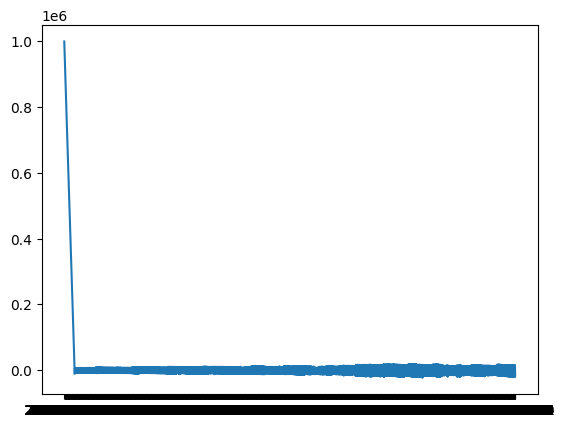

In [ ]:
plt.plot(portfolio_memory_df['date'], portfolio_memory_df['cash'])

In [ ]:
portfolio_memory_df["SPX"].max()

526.0

In [ ]:
df_account_memory

,date,account_value
0,2016-01-04,1.000000e+06
1,2016-01-05,1.000024e+06
2,2016-01-06,9.993654e+05
3,2016-01-07,9.976434e+05
4,2016-01-08,9.966092e+05
...,...,...
1896,2023-07-18,2.306783e+06
1897,2023-07-19,2.312149e+06
1898,2023-07-20,2.296348e+06
1899,2023-07-21,2.297051e+06


In [ ]:
df_daily_return

,date,daily_return
0,2016-01-04,0.000000
1,2016-01-05,0.000024
2,2016-01-06,-0.000659
3,2016-01-07,-0.001723
4,2016-01-08,-0.001037
...,...,...
1896,2023-07-18,0.007166
1897,2023-07-19,0.002326
1898,2023-07-20,-0.006834
1899,2023-07-21,0.000306


In [ ]:
df_actions

,date,actions
0,2016-01-04,[12]
1,2016-01-05,[12]
2,2016-01-06,[12]
3,2016-01-07,[12]
4,2016-01-08,[12]
...,...,...
1895,2023-07-17,[8]
1896,2023-07-18,[-8]
1897,2023-07-19,[8]
1898,2023-07-20,[-8]


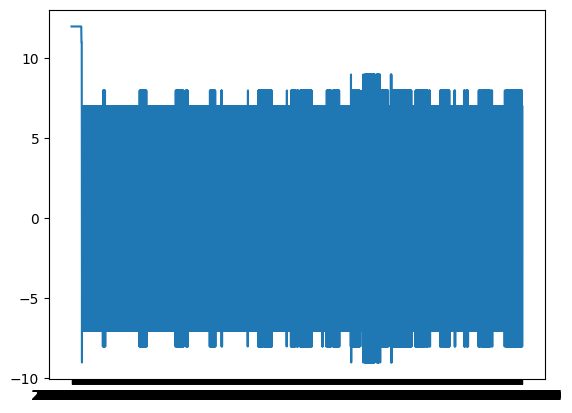

In [ ]:
df_actions['actions'] = df_actions['actions'].apply(lambda x: x[0])
plt.plot(df_actions['date'], df_actions['actions'])

In [ ]:
DRL_strat = convert_daily_return_to_pyfolio_ts(df_daily_return)
perf_func = timeseries.perf_stats 
perf_stats_all = perf_func( returns=DRL_strat, 
                              factor_returns=DRL_strat, 
                                positions=None, transactions=None, turnover_denom="AGB")

In [ ]:
DRL_strat

date
2016-01-04 00:00:00+00:00    0.000000
2016-01-05 00:00:00+00:00    0.000024
2016-01-06 00:00:00+00:00   -0.000659
2016-01-07 00:00:00+00:00   -0.001723
2016-01-08 00:00:00+00:00   -0.001037
                               ...   
2023-07-18 00:00:00+00:00    0.007166
2023-07-19 00:00:00+00:00    0.002326
2023-07-20 00:00:00+00:00   -0.006834
2023-07-21 00:00:00+00:00    0.000306
2023-07-24 00:00:00+00:00    0.004049
Length: 1901, dtype: float64

In [ ]:
df_daily_return

,date,daily_return
0,2016-01-04,0.000000
1,2016-01-05,0.000024
2,2016-01-06,-0.000659
3,2016-01-07,-0.001723
4,2016-01-08,-0.001037
...,...,...
1896,2023-07-18,0.007166
1897,2023-07-19,0.002326
1898,2023-07-20,-0.006834
1899,2023-07-21,0.000306


In [ ]:
perf_stats_all

Annual return           0.117146
Cumulative returns      1.306352
Annual volatility       0.187747
Sharpe ratio            0.684491
Calmar ratio            0.343996
Stability               0.890407
Max drawdown           -0.340546
Omega ratio             1.146277
Sortino ratio           0.951880
Skew                   -0.577005
Kurtosis               15.658797
Tail ratio              0.901552
Daily value at risk    -0.023144
Alpha                   0.000000
Beta                    1.000000
dtype: float64

In [ ]:
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^SPX", 
        start = df_daily_return.loc[0,'date'],
        end = df_daily_return.loc[len(df_daily_return)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')

==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1900, 8)
Annual return          0.113808
Cumulative returns     1.253903
Annual volatility      0.189534
Sharpe ratio           0.664305
Calmar ratio           0.335470
Stability              0.896539
Max drawdown          -0.339250
Omega ratio            1.140467
Sortino ratio          0.923685
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.902529
Daily value at risk   -0.023379
dtype: float64


[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1901, 8)


Start date,2016-01-04
End date,2023-07-24
Total months,90
,Backtest
Annual return,11.715%
Cumulative returns,130.635%
Annual volatility,18.775%
Sharpe ratio,0.68
Calmar ratio,0.34
Stability,0.89
Max drawdown,-34.055%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,34.05,2020-02-19,2020-03-23,2020-08-21,133
1,25.58,2022-01-03,2022-10-12,NaT,NaN
2,19.86,2018-09-20,2018-12-24,2019-04-23,154
3,10.18,2018-01-26,2018-04-02,2018-08-27,152
4,9.66,2020-09-02,2020-09-23,2020-11-16,54


Stress Events,mean,min,max
New Normal,0.06%,-4.13%,2.73%
Covid,0.05%,-12.09%,9.45%


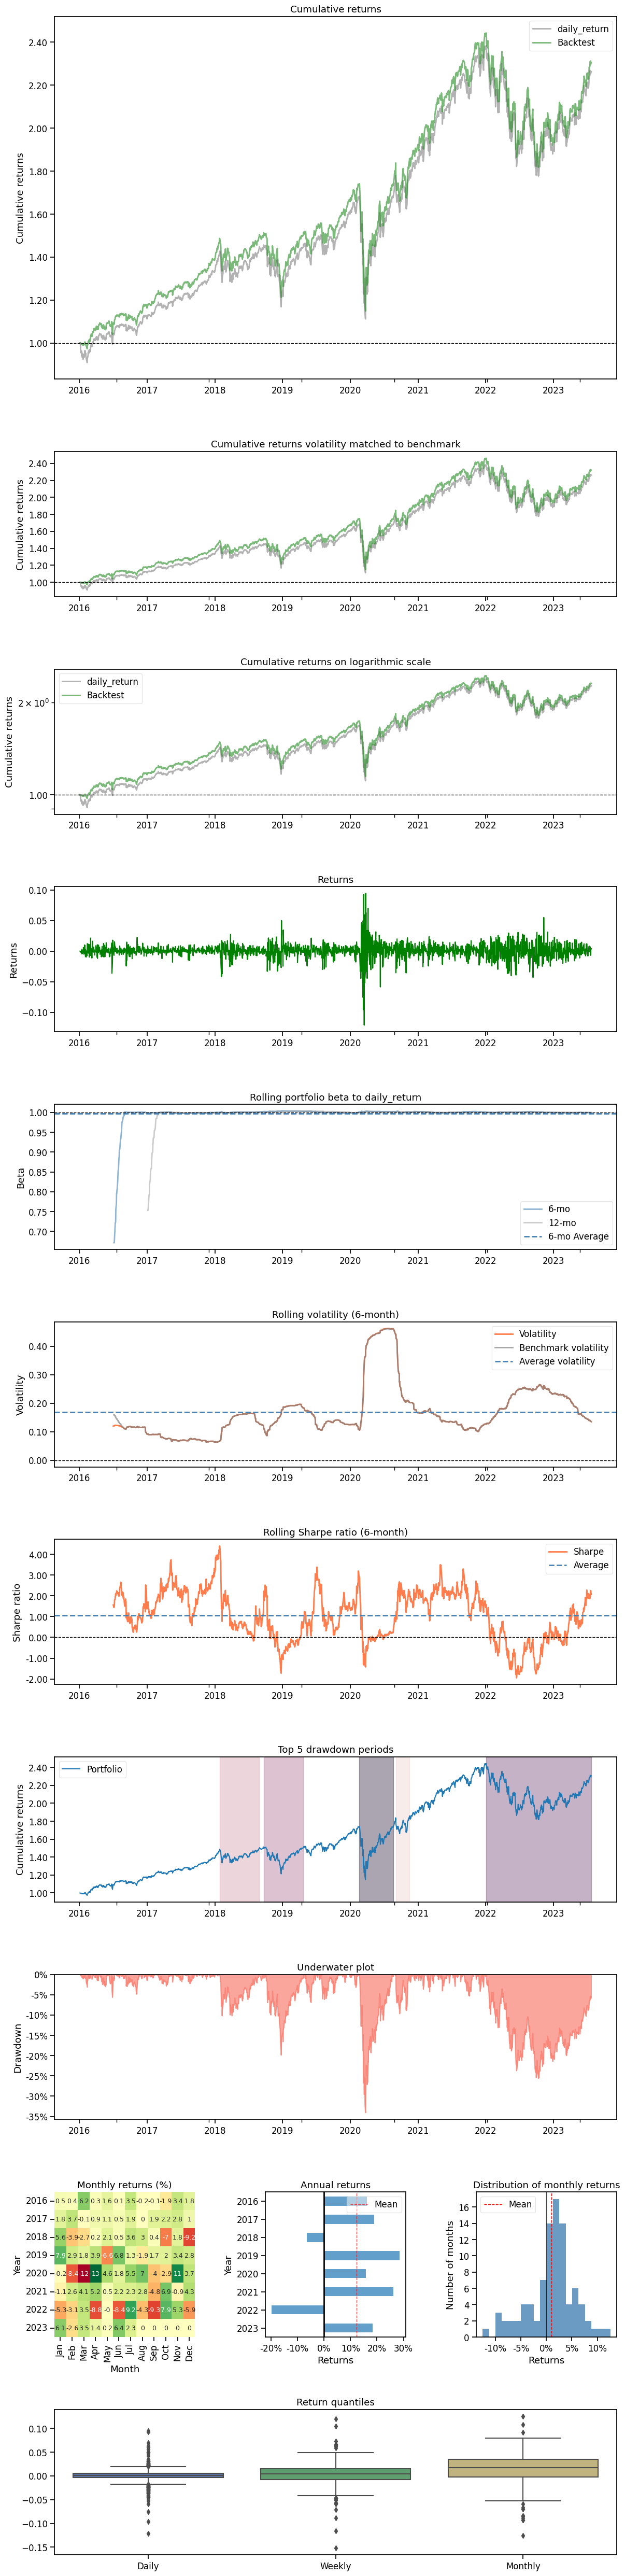

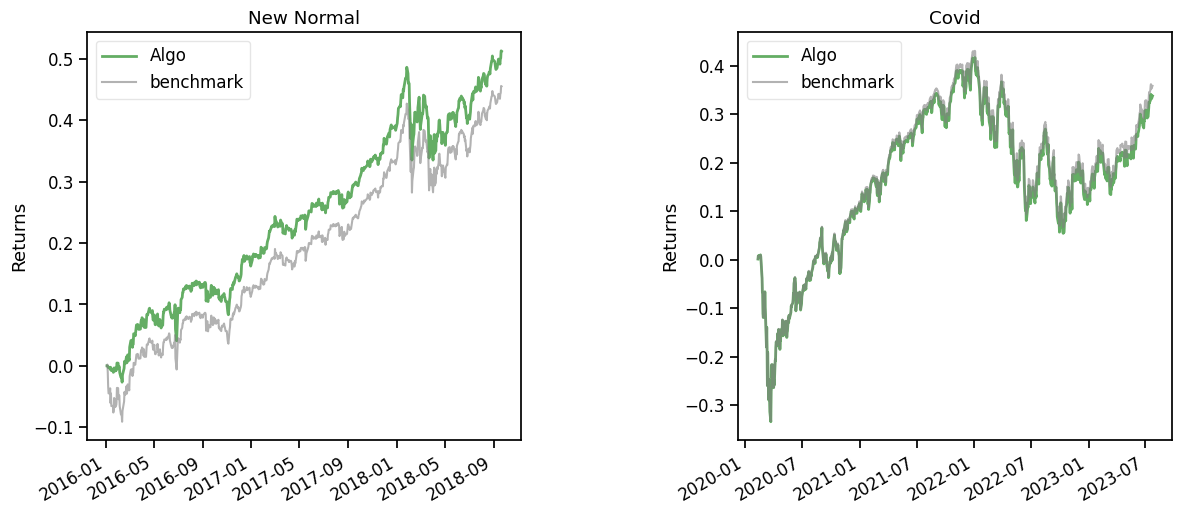

In [ ]:
%matplotlib inline
baseline_df = get_baseline(
        ticker='^SPX', start=df_daily_return.loc[0,'date'], end=test_end
    )

baseline_returns = get_daily_return(baseline_df, value_col_name="close")

with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(returns = DRL_strat,
        
                                       benchmark_rets=baseline_returns, set_context=False)
